In [1]:
import time
import torch
import pandas as pd
import torch.utils.data as data
from src.models import MultiLayerANN, SynapticSNN, LeakySNN, DoubleLeakySNN
from src.train_model import training_loop_stats
from src.graphs import one_graph, multiple_models_one_x

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Parameter count

In [3]:
def list_parameters(model):
    all_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            param = parameter.numel()
            print(f'Name: {name}, weights:{param}')
            all_params += param
    print(f"Number of parameters: {all_params}")

In [4]:
def count_parameters(model):
    all_params = 0
    for name, parameter in model.named_parameters():
        if parameter.requires_grad:
            param = parameter.numel()
            all_params += param
    return all_params

In [5]:
model1 = MultiLayerANN(num_inputs=8, num_hidden=100, num_outputs=1)
model2 = LeakySNN(num_inputs=8, num_hidden=100, num_outputs=1)
model3 = SynapticSNN(num_inputs=8, num_hidden=100, num_outputs=1)
model4 = DoubleLeakySNN(num_inputs=8, num_hidden=100, num_outputs=1)

In [6]:
print("--- MultiLayerAnn ---")
list_parameters(model1)
print("--- LeakySNN ---")
list_parameters(model2)
print("--- SynapticSNN ---")
list_parameters(model3)
print("--- DoubleLeakySNN ---")
list_parameters(model4)

--- MultiLayerAnn ---
Name: lin1.weight, weights:800
Name: lin1.bias, weights:100
Name: lin2.weight, weights:10000
Name: lin2.bias, weights:100
Name: lin3.weight, weights:100
Name: lin3.bias, weights:1
Number of parameters: 11101
--- LeakySNN ---
Name: lin1.weight, weights:800
Name: lin1.bias, weights:100
Name: lif.threshold, weights:100
Name: lif.beta, weights:1
Name: lin2.weight, weights:100
Name: lin2.bias, weights:1
Number of parameters: 1102
--- SynapticSNN ---
Name: lin1.weight, weights:800
Name: lin1.bias, weights:100
Name: lif.threshold, weights:100
Name: lif.beta, weights:1
Name: lin2.weight, weights:100
Name: lin2.bias, weights:1
Number of parameters: 1102
--- DoubleLeakySNN ---
Name: lin1.weight, weights:800
Name: lin1.bias, weights:100
Name: lif1.threshold, weights:100
Name: lif1.beta, weights:1
Name: lif2.threshold, weights:100
Name: lif2.beta, weights:1
Name: lin2.weight, weights:100
Name: lin2.bias, weights:1
Number of parameters: 1203


In [7]:
weights = [[],[],[]]
hidden_values = [1, 2, 5, 15, 20, 25, 30, 35, 40]
for num_hidden in hidden_values:
    model1 = MultiLayerANN(num_inputs=8, num_hidden=num_hidden, num_outputs=1)
    model2 = LeakySNN(num_inputs=8, num_hidden=num_hidden, num_outputs=1)
    model4 = DoubleLeakySNN(num_inputs=8, num_hidden=num_hidden, num_outputs=1)
    weights[0].append(count_parameters(model1))
    weights[1].append(count_parameters(model2))
    weights[2].append(count_parameters(model4))

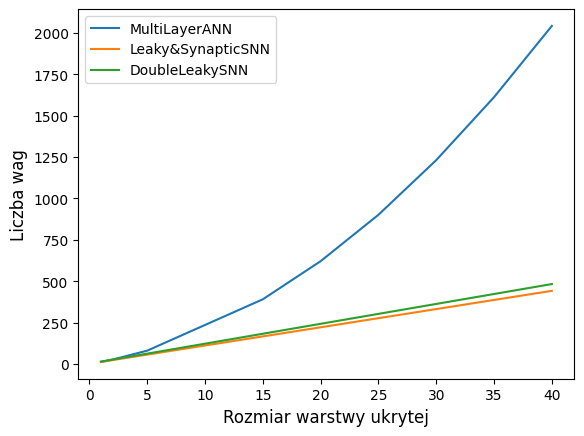

In [8]:
img = multiple_models_one_x(hidden_values, weights, legend=["MultiLayerANN", "Leaky&SynapticSNN", "DoubleLeakySNN"],
                            x_label="Rozmiar warstwy ukrytej", y_label="Liczba wag", textsize=12)

### Data

In [9]:
data06 = pd.read_csv("../data/processed/target06.csv")
data06.drop(columns=["weekday"], inplace=True)

In [10]:
all_data = data.TensorDataset(torch.from_numpy(data06.values[:,:-1]).float(), torch.from_numpy(data06.values[:,-1]).float())
train_dataset, test_dataset = torch.utils.data.random_split(all_data, (round(0.8 * len(all_data)), round(0.2 * len(all_data))))
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

### Forward propagation time
#### 1 step

In [11]:
# CPU
model1 = MultiLayerANN(num_inputs=8, num_hidden=2000, num_outputs=1)
model2 = LeakySNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=1)
model3 = SynapticSNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=1)
model4 = DoubleLeakySNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=1)
models = [model1, model2, model3, model4]
times = [[], [], [], []]

In [12]:
for _ in range(5):
    for values, targets in test_loader:
        for i, model in enumerate(models):
            time1 = time.time()
            model(values)
            time2 = time.time()
            times[i].append(time2 - time1)

In [13]:
time_avg = [0., 0., 0., 0.]
for model, values in enumerate(times):
    time_avg[model] = sum(values)/len(values)
time_avg

[0.009011094353415749,
 0.0007928536155007102,
 0.0008330206437544389,
 0.0013384879719127308]

### 20 steps

In [14]:
model1 = MultiLayerANN(num_inputs=8, num_hidden=2000, num_outputs=1)
model2 = LeakySNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=20)
model3 = SynapticSNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=20)
model4 = DoubleLeakySNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=20)
models = [model1, model2, model3, model4]
times = [[], [], [], []]

In [15]:
for _ in range(5):
    for values, targets in test_loader:
        for i, model in enumerate(models):
            time1 = time.time()
            model(values)
            time2 = time.time()
            times[i].append(time2 - time1)

In [16]:
time_avg = [0., 0., 0., 0.]
for model, values in enumerate(times):
    time_avg[model] = sum(values)/len(values)
time_avg

[0.008786714727228338,
 0.011688295711170544,
 0.01333945707841353,
 0.024132497093894267]

### Learning time

In [17]:
model1 = MultiLayerANN(num_inputs=8, num_hidden=2000, num_outputs=1)
model2 = LeakySNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=25)
model3 = SynapticSNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=50)
model4 = DoubleLeakySNN(num_inputs=8, num_hidden=2000, num_outputs=1, num_steps=25)

In [18]:
training_times = [training_loop_stats(model1, train_loader, test_loader, device, num_epochs=8, collect_time=True),
training_loop_stats(model2, train_loader, test_loader, device, num_epochs=8, collect_time=True),
training_loop_stats(model3, train_loader, test_loader, device, num_epochs=8, collect_time=True),
training_loop_stats(model4, train_loader, test_loader, device, num_epochs=8, collect_time=True)]

100%|██████████| 8/8 [01:16<00:00,  9.55s/it]


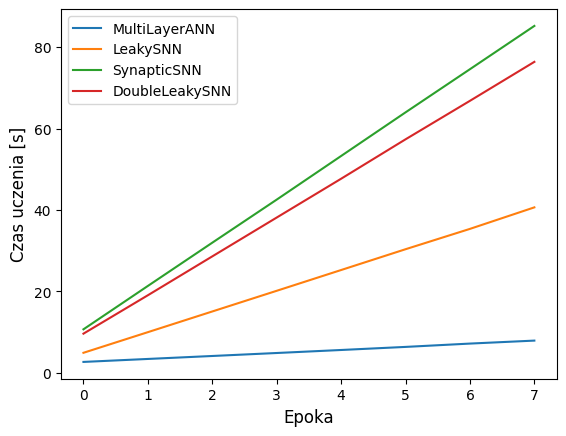

In [19]:
img = multiple_models_one_x([i for i in range(8)], training_times, legend=["MultiLayerANN", "LeakySNN", "SynapticSNN", "DoubleLeakySNN"],
                            x_label="Epoka", y_label="Czas uczenia [s]", textsize=12)